# PyTorch Fundamentals 

PyTorch is a deep learning framework that uses tensors as its core data structure. A tensor is essentially a multi-dimensional array (just like a NumPy array) that can run on GPU for accelerated computing. Unlike NumPy, PyTorch tensors also support automatic differentiation, which is crucial for machine learning. In practice, you can think of tensors as flexible containers for data – vectors, matrices, images, etc. – that PyTorch can track through computations to compute gradients for learning.

## 1.1 Tensors and Tensor Operations
Let’s begin by importing PyTorch and creating some tensors. We’ll see how to perform basic operations with them.

In [1]:
import torch

# Creating tensors (PyTorch uses torch.Tensor class)
# 1. Scalar (0-d tensor)
scalar = torch.tensor(3.14)
print("Scalar tensor:", scalar)

# 2. 1-D Vector
vector = torch.tensor([1.0, 2.0, 3.0])
print("Vector tensor:", vector)

# 3. 2-D Matrix 
matrix = torch.tensor([[1, 2, 3],
                       [4, 5, 6]])
print("Matrix tensor:\n", matrix)

# You can check tensor attributes like shape and type:
print("Vector shape:", vector.shape)
print("Matrix dtype:", matrix.dtype)

# Basic tensor operations (similar to NumPy):
x = torch.tensor([10.0, 20.0, 30.0])
y = torch.tensor([4.0, 5.0, 6.0])
print("x + y =", x + y)           # element-wise addition
print("x * y =", x * y)           # element-wise multiplication
print("x dot y =", torch.dot(x, y))  # dot product
print("x mean =", x.mean())       # compute mean


Scalar tensor: tensor(3.1400)
Vector tensor: tensor([1., 2., 3.])
Matrix tensor:
 tensor([[1, 2, 3],
        [4, 5, 6]])
Vector shape: torch.Size([3])
Matrix dtype: torch.int64
x + y = tensor([14., 25., 36.])
x * y = tensor([ 40., 100., 180.])
x dot y = tensor(320.)
x mean = tensor(20.)


In the code above, we created:

* A **scalar** tensor (just a single number).
* A **vector** (1-dimensional tensor) with 3 elements.
* A **matrix** (2-dimensional tensor) with 2 rows and 3 columns.

We then performed some basic operations: element-wise addition, multiplication, dot product, etc. PyTorch overloads standard Python arithmetic operators for tensors, so `x + y` works as you’d expect (adding corresponding elements). You can also call functions like `torch.dot` for dot product or tensor methods like `x.mean()`.

Notice that PyTorch tensors have attributes like shape (also called size) and dtype (data type). By default, torch uses 32-bit floating point (`torch.float32`) for many operations, which is usually what we want for neural network training.

## 1.2 Autograd and Gradients
One of the most powerful features of PyTorch is its **autograd** (automatic differentiation) engine. Autograd allows PyTorch to **compute gradients automatically** for any tensor operations, which is essential for model training. When we set `requires_grad=True` on a tensor, PyTorch will record all operations involving that tensor and build a computational graph. Then, by calling `.backward()`, it computes the gradient of some final result (like a loss) with respect to that tensor (and any other tensors with `requires_grad`).

In machine learning, we use gradients to update model parameters in the direction that reduces the loss (via gradient descent). Autograd frees us from manually computing these derivatives.

Let's see a simple example of **autograd** in action.  
We will create a tensor `x`, enable gradients on it, and then do a simple operation:

$$
y = x^2
$$

We know the derivative:

$$
\frac{dy}{dx} = 2x
$$

So at:

$$
x = 2
$$

we expect the gradient to be:

$$
\frac{dy}{dx} = 4
$$


In [2]:
# Example: Using autograd to compute a derivative
x = torch.tensor(2.0, requires_grad=True)   # define a tensor with gradients tracking
y = x ** 2                                  # y = x^2
y.backward()                                # compute dy/dx
print("x.grad =", x.grad)                   # should be 4, since dy/dx = 2*x at x=2


x.grad = tensor(4.)


When we run this, PyTorch will compute the gradient:

$$
\frac{dy}{dx}
$$

and store it in `x.grad`. You should see: 
$$x.grad = tensor(4.)$$ 
confirming that the gradient is 4 as expected.  

Under the hood, PyTorch built a graph of the operation:

$$
y = x^2
$$

and used the chain rule to get the derivative. This automatic gradient computation is what powers neural network training in PyTorch ([docs](https://pytorch.org/docs/)).

---

**Key concept:** In training, we forward propagate inputs through the model to get an output and a loss, and then backpropagate to get gradients of the loss w.r.t. each parameter ([docs](https://pytorch.org/docs/)).  
PyTorch’s autograd does the backpropagation for us – we just call `.backward()` on the loss tensor, and it computes all the necessary gradients.


# 1.3 Basic Training Workflow in PyTorch

Now that we know about tensors and autograd, let’s outline a basic workflow for training a machine learning model (like a neural network) in PyTorch. The typical steps are:

1. **Prepare the data** – load your dataset and convert it into tensors (and usually create a `DataLoader` for batching, though for simplicity we’ll skip `DataLoader` for now).
2. **Define the model** – specify the architecture. In PyTorch, you can either use built-in layers from `torch.nn` or define your own `nn.Module`.  
   Example: a simple linear model can be defined with `nn.Linear`.
3. **Define the loss function** – e.g. Mean Squared Error for regression, or Cross-Entropy for classification. PyTorch provides many losses in `torch.nn` (like `nn.MSELoss`).
4. **Define the optimizer** – e.g. Stochastic Gradient Descent (SGD), Adam, etc., from `torch.optim`. You tell it which model parameters to update and the learning rate.
5. **Training loop** – iterate over the data for multiple epochs:  
   - Forward pass: `model(x)` to get predictions  
   - Compute loss  
   - `loss.backward()` to get gradients  
   - `optimizer.step()` to update parameters  
   - Don’t forget `optimizer.zero_grad()` at each iteration to reset gradients  

We will see these steps in action when we implement **linear regression** below.  
For a small problem you might not use batches, but the loop structure is the same.  
PyTorch will handle the gradient calculations and weight updates, so you can focus on the model logic.


# 2. Linear Regression: Your First Model

Linear regression is the simplest machine learning model for supervised learning.  
It assumes a linear relationship between the input variables and the output (target).  

In the case of a single input variable (univariate linear regression), this means we try to fit a straight line:

$$
\hat{y} = wx + b
$$

that best predicts the target $y$ from the input $x$.  
The parameters $w$ (weight or slope) and $b$ (bias or intercept) define the line.  

Linear regression finds the values of $w$ and $b$ that minimize the prediction errors on the training data ([source](https://oi.readthedocs.io)).

> **Statistics view:**  
> “Linear regression is a linear approach to modeling the relationship between a scalar response (dependent variable) and one or more explanatory variables (independent variables)” ([source](https://oi.readthedocs.io)).

Here we'll focus on **simple linear regression** (one independent variable) for clarity.  
Despite its simplicity, linear regression introduces the **core ideas of model training**.


## 2.1 Problem Setup – A Simple Dataset

To make this practical, let's consider an example scenario:  
We want to predict a student's exam score based on how many hours they studied.  

- Input ($x$): hours studied  
- Target ($y$): exam score  

We expect a **positive linear relationship**: more hours → higher score (up to a point).  
Of course, real data will have some noise.

Recall from the lecture slides: the (perhaps tongue-in-cheek) idea that your chances of landing an AI/ML internship might increase linearly with the number of MLF sessions you attend. That is also a one-dimensional linear regression problem. Here, we'll use the study hours vs score scenario, but the mechanics are identical.

Let's **generate a synthetic dataset** for study hours vs exam score. We will assume the true relationship is roughly `score = 5 * hours + 50` (just an arbitrary linear trend), and add some random noise to simulate variability among students.

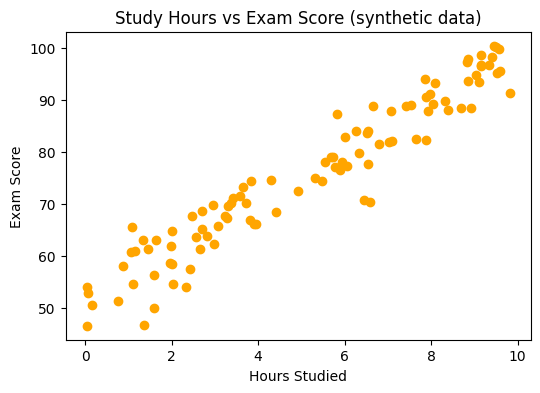

In [3]:
import matplotlib.pyplot as plt

# Set a seed for reproducibility
torch.manual_seed(42)

# Generate 100 random study hours between 0 and 10
N = 100
hours = 10 * torch.rand(N)  # uniform random in [0, 10]
# Generate scores with a linear relation to hours plus some noise
true_w = 5.0    # true slope (points per hour)
true_b = 50.0   # true intercept (base score with 0 hours)
noise = torch.randn(N) * 5.0  # random noise (standard deviation 5)
scores = true_w * hours + true_b + noise

# Quick visualization of the data
plt.figure(figsize=(6,4))
plt.scatter(hours.numpy(), scores.numpy(), color='orange')
plt.xlabel("Hours Studied")
plt.ylabel("Exam Score")
plt.title("Study Hours vs Exam Score (synthetic data)")
plt.show()

In this code, we created `hours` (our x values) and `scores` (our y values).  
We defined the "true" underlying line as:

$$
y = 5 \cdot x + 50
$$

and added Gaussian noise (`torch.randn`) to make the data imperfect.  
The plot should show a scattered cloud of points roughly forming an upward sloping line. (Each point represents one student.)

## 2.2 The Linear Regression Model and Loss Function

Our goal is to **learn** the parameters of a line:

$$
y = wx + b
$$

that best fits this data. “Best fit” in a least-squares sense means the line should minimize the **Mean Squared Error (MSE)** between its predictions and the actual data points.  
The MSE loss for a dataset is defined as:

$$
MSE(w, b) = \frac{1}{N} \sum_{i=1}^{N} (\hat{y}^{(i)} - y^{(i)})^2,
$$

where $\hat{y}^{(i)} = w x^{(i)} + b$ is the prediction for the i-th data point, and $y^{(i)}$ is the true target.  
MSE essentially measures the average squared error – we square the differences so that negative/positive errors don’t cancel out, and to penalize large errors more.

---

**Our task:** find $w$ and $b$ that minimize MSE.  
For linear regression, there is a known closed-form solution, but here we'll solve it using **gradient descent**, which is the basis for training most ML models.  

Gradient descent is an iterative optimization algorithm that takes steps proportional to the negative of the gradient of the loss function ([oi.readthedocs.io](https://oi.readthedocs.io)).  
In simpler terms, we repeatedly adjust $w$ and $b$ in the direction that lowers the MSE.

---

### Gradient descent update rules:

$$
w := w - \alpha \frac{\partial MSE}{\partial w}, \quad 
b := b - \alpha \frac{\partial MSE}{\partial b},
$$

where $\alpha$ is the **learning rate** – a small positive number that controls how big a step we take on each iteration.  
If $\alpha$ is too large, we might overshoot the minimum and diverge; if it’s too small, learning will be very slow.  
Choosing a good learning rate often requires tuning.

---

For our linear model, we can derive the gradients of MSE w.r.t. $w$ and $b$.  
If 

$$
L = \frac{1}{N} \sum (wx_i + b - y_i)^2,
$$

then:

$$
\frac{\partial L}{\partial w} = \frac{2}{N} \sum_{i=1}^N (wx_i + b - y_i)x_i, \quad
\frac{\partial L}{\partial b} = \frac{2}{N} \sum_{i=1}^N (wx_i + b - y_i).
$$

---

You don’t need to memorize these formulas – we’ll implement them in code.  
But it’s good to see that computing these involves summing over all data points.

---

Now, let's implement **manual gradient descent** to find $w$ and $b$ that fit our data.  
We’ll start with random initial guesses for $w$ and $b$, then iteratively update them using the gradients.


## 2.3 Manual Gradient Descent Implementation (Exercise)

We will go through the training loop step by step. To help you learn, parts of the code are left as **TODO** for you to fill in.

---

### Steps:

1. Initialize parameters $w$ and $b$ randomly.  
2. For a number of epochs (iterations):  
   - Compute predictions $\hat{y} = wx + b$ for all data points.  
   - Compute the MSE loss (average of squared errors).  
   - Compute the gradients $\frac{\partial L}{\partial w}$ and $\frac{\partial L}{\partial b}$ using the formulas above.  
   - Update $w$ and $b$ with the gradient descent step.  
3. Print the learned parameters and final loss.  

---

Let's code this. Remember, the goal is to reduce the loss each step by nudging $w$ and $b$ in the opposite direction of the gradient.


In [5]:
# Initialize parameters
w = torch.randn(1, requires_grad=False)  # start with a random weight
b = torch.randn(1, requires_grad=False)  # start with a random bias

learning_rate = 0.01
epochs = 1000

# Lists to store loss values for plotting
loss_values = []

for epoch in range(epochs):
    # Forward pass: compute predictions and loss
    y_pred = w * hours + b                     # model predictions for all N data points
    error = y_pred - scores                    # error term (prediction - true value)
    loss = torch.mean(error ** 2)              # MSE loss for this epoch
    loss_values.append(loss.item())
    
    # Compute gradients (dL/dw and dL/db) - using the formulas derived above
    grad_w = None  # TODO: compute gradient w.rt. w (use (error * hours))
    grad_b = None  # TODO: compute gradient w.rt. b (use error)
    
    # Update parameters using gradient descent
    w = w - learning_rate * grad_w
    b = b - learning_rate * grad_b

# After training, let's see the results
print(f"Learned weight w: {w.item():.3f}")
print(f"Learned bias b: {b.item():.3f}")
print(f"Final training MSE: {loss_values[-1]:.3f}")

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

Exercise: Fill in the TODO lines above to calculate grad_w and grad_b. Use the formulas:
- `grad_w = 2 * sum((y_pred - scores) * hours) / N`
- `grad_b = 2 * sum(y_pred - scores) / N.`

(Hint: `error = y_pred - scores` is already computed, and `N = len(hours)`). 

After that, run the loop and observe the printed results.

If your implementation is correct, the loss should steadily decrease.  
The learned `w` and `b` should end up near the true values ~5 and ~50 (they won’t be exact due to noise).  
The final MSE should also be much lower than the initial MSE.  
(Remember, initially $w, b$ were random, so the starting error was large).

**Understanding the output:**  
You might see something like: `Learned weight w: 4.8`, `Learned bias b: 51.2` which is close to the true slope 5.0 and intercept 50.0 we used to generate the data.  
The final MSE might be around 20–30 ${points}^2$ (since our noise had std 5, the best possible MSE is around 25).  
This means on average the prediction error is about 5 points, which makes sense given the noise.

Why didn’t we get **exactly** 5.0 and 50.0?  
Because the data had random noise – there isn’t a single perfect line that goes through all points.  
Gradient descent finds the best compromise line that minimizes squared errors.


It’s worth noting that for a simple linear regression, we **could** solve for the optimal $w, b$ analytically (using a formula or linear algebra).  
However, in more complex models or higher dimensions, that isn’t feasible.  
Instead, we rely on iterative methods like gradient descent for thousands or millions of parameters.  
As the lecture pointed out, *“no one does this math by hand… you can do this through coding!”*.  
Now you’ve seen how to do exactly that.

## 2.4 Visualizing the Results

Let's visualize what our learned model looks like compared to the data, and also see how the loss decreased over training. We’ll plot the data points and the learned regression line, as well as a curve of the MSE loss over epochs.

ValueError: x and y must have same first dimension, but have shapes (1000,) and (1,)

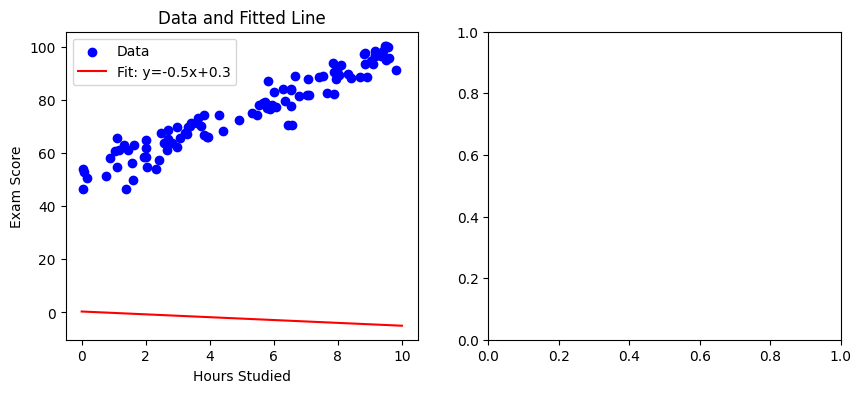

In [6]:
# Plot the data and the learned line, and the loss curve
plt.figure(figsize=(10,4))

# Left: scatter plot of data and fitted line
plt.subplot(1, 2, 1)
plt.scatter(hours.numpy(), scores.numpy(), color='blue', label='Data')
# plot the learned line:
x_line = torch.tensor([0.0, 10.0])  # two end-points (min and max hours)
y_line = w * x_line + b
plt.plot(x_line.numpy(), y_line.detach().numpy(), color='red', label=f'Fit: y={w.item():.1f}x+{b.item():.1f}')
plt.xlabel("Hours Studied")
plt.ylabel("Exam Score")
plt.title("Data and Fitted Line")
plt.legend()

# Right: loss curve
plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss_values, color='purple')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss Curve")

plt.tight_layout()
plt.show()


*Figure: (Left) Scatter plot of the study hours vs exam scores dataset (blue points) and the linear regression line fitted by our model (red line). (Right) The MSE loss decreasing over training iterations. The loss curve shows that gradient descent successfully reduced the error over time, leveling off as it nears the minimum.*

You can see that the red line fits the data trend quite well.  
Most points are fairly close to the line, which indicates our model captured the relationship.  
The loss curve on the right starts higher and slopes downward, confirming that our training process was working – the errors got smaller and smaller.  
The curve typically flattens out when further improvements are minimal (convergence).

---

Try experimenting with the learning rate or number of epochs and re-running the training to see how it affects the loss curve.  

For example, what if you use: `learning_rate = 0.1` (ten times larger)? You might observe the loss diverging or oscillating if the rate is too large. This highlights why picking a proper learning rate is important.


In [7]:
import torch.nn as nn
import torch.optim as optim

# Define a simple linear regression model using nn.Linear
model = nn.Linear(1, 1)  # 1 input feature, 1 output feature

# Define the Mean Squared Error loss function
loss_fn = nn.MSELoss()

# Define an optimizer (Stochastic Gradient Descent) to update our model parameters
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Prepare data shape: currently hours and scores are shape [N], we need [N,1] for model
X_train = hours.view(-1, 1)   # reshape to (100, 1)
y_train = scores.view(-1, 1)

# Training loop (similar structure, but using PyTorch machinery)
epochs = 1000
for epoch in range(epochs):
    # Forward pass: compute predictions
    y_pred = model(X_train)               # model does: w*x + b internally
    loss = loss_fn(y_pred, y_train)      # compute MSE loss between predictions and true scores
    
    # Backward pass and optimization step
    optimizer.zero_grad()   # reset gradients from previous step
    loss.backward()         # compute gradients of loss w.rt. model parameters
    optimizer.step()        # update parameters (w and b) using those gradients

# After training, examine the learned parameters
w_hat = model.weight.item()
b_hat = model.bias.item()
print(f"Model learned w = {w_hat:.3f}, b = {b_hat:.3f}")
print(f"Final loss = {loss.item():.3f}")

Model learned w = 4.829, b = 50.749
Final loss = 16.620


# 2.5 Using PyTorch `nn` and `optim` (Built-in Training)

We just implemented linear regression “from scratch” using basic PyTorch tensor operations. While this is great for learning, in practice we can leverage PyTorch’s high-level APIs to do the same job more succinctly. PyTorch provides:

- `nn.Linear` – a linear layer (module) that internally holds a weight and bias parameter and computes $wx + b$.
- **Loss functions** in `torch.nn`, like `nn.MSELoss` which we can use for MSE.
- **Optimizers** in `torch.optim` that update parameters for us, e.g. `torch.optim.SGD`.

We will now redo the linear regression using these tools. This will look more like typical PyTorch code in research or production.


In [ ]:
import torch.nn as nn
import torch.optim as optim

# Define a simple linear regression model using nn.Linear
model = nn.Linear(1, 1)  # 1 input feature, 1 output feature

# Define the Mean Squared Error loss function
loss_fn = nn.MSELoss()

# Define an optimizer (Stochastic Gradient Descent) to update our model parameters
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Prepare data shape: currently hours and scores are shape [N], we need [N,1] for model
X_train = hours.view(-1, 1)   # reshape to (100, 1)
y_train = scores.view(-1, 1)

# Training loop (similar structure, but using PyTorch machinery)
epochs = 1000
for epoch in range(epochs):
    # Forward pass: compute predictions
    y_pred = model(X_train)               # model does: w*x + b internally
    loss = loss_fn(y_pred, y_train)      # compute MSE loss between predictions and true scores
    
    # Backward pass and optimization step
    optimizer.zero_grad()   # reset gradients from previous step
    loss.backward()         # compute gradients of loss w.rt. model parameters
    optimizer.step()        # update parameters (w and b) using those gradients

# After training, examine the learned parameters
w_hat = model.weight.item()
b_hat = model.bias.item()
print(f"Model learned w = {w_hat:.3f}, b = {b_hat:.3f}")
print(f"Final loss = {loss.item():.3f}")

In a few lines, we have done the same thing as before! Let’s break down what happened:

- `nn.Linear(1,1)` creates a linear layer (essentially a container for one weight and one bias). We could also create a custom class inheriting `nn.Module`, but this is convenient for a single-layer model.
- `optimizer = optim.SGD(model.parameters(), lr=0.01)` tells PyTorch we want to use SGD to adjust `model.parameters()` (which are $w$ and $b$ of the linear layer) with a 0.01 learning rate.
- In the loop: `model(X_train)` produces predictions; `loss_fn(y_pred, y_train)` computes the MSE; `loss.backward()` computes gradients; `optimizer.step()` applies the gradient descent update to the parameters. PyTorch’s autograd takes care of computing the same gradients we derived manually.

After training, you should find `model.weight` and `model.bias` are very close to the values we got before (and close to 5 and 50). The final loss will also match what we saw with manual training. This confirms that using PyTorch’s built-in methods achieves the same result.

One advantage of using the high-level API is that it’s easy to swap different optimizers or even build more complex models with minimal code change. For example, you could replace `optim.SGD` with `optim.Adam` (a more advanced optimizer) and it would work similarly.


## 2.6 Discussion and Next Steps

Congratulations – you have implemented and trained a linear regression model using two approaches! 🎉  
This simple exercise illustrated the core ideas of machine learning training: we defined a model with parameters, chose a loss function (MSE), computed gradients, and updated the parameters to reduce the loss. This is the essence of training any machine learning model, from linear regression to deep neural networks.

A few takeaways and things to keep in mind:

- **Model complexity:** Linear regression is a very simple, *linear* model. It can capture linear trends but cannot fit more complex patterns (for instance, if the true relationship is quadratic or otherwise nonlinear). Many real-world problems aren’t linear, which is why we move to more complex models (like neural networks) in later weeks.

- **Over/Under-shooting:** We briefly mentioned learning rate. If your training diverged or the loss didn’t go down, the learning rate might have been too high (causing overshooting). If it was extremely slow, maybe it was too low. This hyperparameter often needs tuning.

- **Autograd magic:** We relied on autograd for the second part. It’s good to know that under the hood, PyTorch built a computational graph of our model and computed gradients using the chain rule, just like we did manually. For complex models, autograd is indispensable.

- **No Free Lunch:** Our final linear model didn’t fit every point exactly (due to noise). Also, real data can have outliers or non-linear patterns that linear regression won’t handle well. In practice, we consider more robust models or data preprocessing for such cases. But linear regression is still a fundamental starting point.


**Great job on completing Week 1!** You’ve laid the groundwork in PyTorch and linear models, which we will build upon in the coming weeks.